## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [77]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import re
from sklearn.model_selection import train_test_split #using sklearn only for splitting data
from scipy import spatial
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/kush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load dataset

In [2]:
config = {
    "dataset_file":"./emails.txt", 
    "output_file": "./output_q3.txt",
    "split_ratio": 0.02
}

In [3]:
with open(config['dataset_file'], 'r') as inFile:
    dataset = inFile.readlines()
df = pd.DataFrame(dataset)

In [4]:
df[[0, 'string']] = df[0].str.split("\t", expand=True)
df = df.rename(columns = {0:'type','string': 'string'})

In [5]:
def one_hot(mail_type):
    if mail_type == "ham":
        return 0
    else: 
        return 1

In [6]:
df['type'] = df['type'].apply(one_hot) 

ham: 0,  spam: 1

### Preprocess data

In [42]:
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
from scipy.spatial.distance import cdist

[nltk_data] Downloading package stopwords to /home/kush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kush/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kush/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
emails = df.to_numpy()

In [9]:

for i, string in enumerate(emails[:, 1]):
    string = re.sub(r"[^a-zA-Z0-9]", " ", string.lower()) #remove puncs and lower
    string = word_tokenize(string)                        #tokanize
    new_string = []
    for word in string:       
        if word not in stop_words:                        #remove stop_words
            word = lem.lemmatize(word)                    #Lemmatize                
            new_string.append(word)
    emails[i, 1] = new_string
    
    

In [10]:
texts = emails[:, 1]
labels = emails[:, 0]

In [11]:
def calc_Vocab(data):
    total_words = []
    for l in data:
        total_words.extend(l)
    total = list(set(total_words))
    return total    

In [12]:
def calc_tf(t, d):
    return d.count(t)/len(d)

In [13]:
def calc_df(tf):
    temp = tf.astype(bool).sum()
    df = dict(zip(list(tf), temp))
    return df
    

In [14]:
def calc_tfidf(data):
    vocab = calc_Vocab(data)
    tf = []
    N = len(data)
    for mail in data:
        word_dic = dict.fromkeys(vocab, 0)
        for word in mail:
            word_dic[word] = calc_tf(word, mail)
        tf.append(word_dic)
    tf = pd.DataFrame(tf)
    
    return tf
        

In [15]:
tf = calc_tfidf(texts)

In [16]:
N = len(texts)

In [17]:
tf_arr = tf.to_numpy()
df = calc_df(tf)   
df_arr = np.array(list(df.values()))
N_arr = np.full( shape=len(list(tf)), fill_value=N, dtype=np.int )
idf = np.log10(np.divide(N_arr, df_arr+1))

In [18]:
tfidf = tf_arr*idf

In [19]:
tfidf_df = pd.DataFrame(tfidf, columns= list(tf))

### Split data

In [20]:
train_data, val_data, train_label, val_label = train_test_split(tfidf, labels, test_size=config['split_ratio'], random_state = 37)

### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data

In [23]:
#caculate cosine distance 


In [57]:
def get_similarity(a, b, _type):
    if _type == 'cos':
        return 1 - spatial.distance.cosine(a, b)
    elif _type == 'euc':
        return 1/np.linalg.norm(a,b)
    elif _type == 'man':
        return 1/cdist(a, b, metric='cityblock')

In [58]:
def get_similarity(val_data, train_data, _type):
    similarity_vec = []
    for vec in val_data:
        cosin_1 = []
        for train_vec in train_data:
            cosin = get_cosine(train_vec, vec)
            cosin_1.append(cosin)
        similarity_vec.append(cosin_1)
    return similarity_vec

### TF-IDF Implementation

In [59]:
def neighbors(similarity,k_value):knn = KNeighborsClassifier(n_neighbors=5)
    k_n_n = []
    for i in range(k_value):
        max_sim = 0
        max_sim_user = 0
        for i, sim in enumerate(similarity):
            if i in k_n_n:
                continue
            elif max_sim <= sim:
                max_sim_user = i
                max_sim = sim
        k_n_n.append(max_sim_user)
    return k_n_n

In [60]:
def pridict(knn, label):
    sumi = 0
    for n in knn:
        sumi += label[n] 
    if sumi > len(knn)/2:
        return 1
    else:
        return 0

In [61]:
def get_tp_fp_fn(pridictions, val_label):
    tp = 0
    fp = 0
    fn = 0
    for i in range(len(pridictions)):
        if pridictions[i] == 1 and val_label[i] == 1:
            tp += 1
        if pridictions[i] == 1 and val_label[i] == 0:
            fp += 1
        if pridictions[i] == 0 and val_label[i] == 1:
            fn += 1
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    F1 = 2*precision*recall/(precision+recall)
    return recall, precision, F1

    

***1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] and compare with the Cosine Similarity distance results.***

In [62]:

similarity_vec_cosin = get_similarity(val_data, train_data, 'cos')
# similarity_vec_eucd = get_similarity(val_data, train_data, 'euc')
# similarity_vec_man = get_similarity(val_data, train_data, 'man')

/home/kush/.local/lib/python3.8/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [71]:
k = 4

cosin_pridictions = []
# euc_pridictions = []
# man_pridictions = []
for sim in similarity_vec_cosin:
    knn = neighbors(sim, k)
    cosin_pridictions.append(pridict(knn, train_label))
# for sim in similarity_vec_eucd:
#     knn = neighbors(sim, k)
#     euc_pridictions.append(pridict(knn, train_label))
# for sim in similarity_vec_man:
#     knn = neighbors(sim, k)
#     man_pridictions.append(pridict(knn, train_label))

In [72]:
recall_cos, precision_cos, F1_cos = get_tp_fp_fn(cosin_pridictions, val_label)
# recall_euc, precision_euc, F1_euc = get_tp_fp_fn(euc_pridictions, val_label)
# recall_man, precision_man, F1_man = get_tp_fp_fn(man_pridictions, val_label)

***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

***3. Report Mean Squared Error(MSE), Mean-Absolute-Error(MAE), R-squared (R2) score in a tabular form***

In [73]:
print(recall_cos, precision_cos, F1_cos)

0.6923076923076923 1.0 0.8181818181818181


***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing R2 score vs k.***

In [75]:
k_vals = [1,3,5,7,11,17,23,28]
F1 = []
for k in k_vals:
    cosin_pridictions = []
    for sim in similarity_vec_cosin:
        knn = neighbors(sim, k)
        cosin_pridictions.append(pridict(knn, train_label))
    recall, precision, F1_val = get_tp_fp_fn(cosin_pridictions, val_label)
    F1.append(F1_val)

In [81]:
F1

[0.7826086956521738,
 0.8695652173913044,
 0.8181818181818181,
 0.8181818181818181,
 0.8181818181818181,
 0.8695652173913044,
 0.8695652173913044,
 0.8181818181818181]

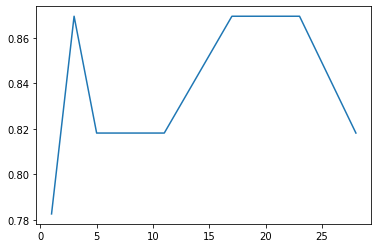

In [80]:
plt.plot(k_vals, F1)

### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

In [84]:
from sklearn.neighbors import KNeighborsClassifier
kneigh = KNeighborsClassifier(n_neighbors=5)
kneigh.fit(train_data, train_label.astype(int))


KNeighborsClassifier()

In [86]:
y_pred = kneigh.predict(val_data)

In [87]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [88]:
recall_skl, preci_skl, F1_skl = get_tp_fp_fn(y_pred, val_label)

***Compare both the models result.***

In [73]:
print(recall_cos, precision_cos, F1_cos)

0.6923076923076923 1.0 0.8181818181818181


In [89]:
print(recall_skl, preci_skl, F1_skl)

0.3076923076923077 1.0 0.47058823529411764


***What is the time complexity of training using KNN classifier?***

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***